(제목)사람인 채용공고 데이터를 기반으로 한 직군별·기술별·지역별 채용 분석


**목차**

1, 데이터 수집
- 사람인 it직군 크롤링

2. 데이터 가공/정제
- 중복 제거, 결측치 제거, 기술 키워드 정규화
- 데이터 정보
- 데이터 헤드 미리보기

3. 요구 기술별 TOP20

4. 직군별 통계

5. 지역별 채용 수요


 **1** **.데이터 수집**

[2025년 11월 26일 사람인 직업별 it직군 카테고리 크롤링]

In [ ]:
# 사람인 채용공고 크롤링

# 1) 필수 패키지 설치
!pip install requests beautifulsoup4 pandas tqdm

# 2) 라이브러리 임포트
import re
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import Counter
from tqdm import tqdm

# --- 유틸: 헤더
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'
}

# --- 1) requests HTML 요청
def fetch_html_requests(url, params=None, timeout=10):
    resp = requests.get(url, headers=HEADERS, params=params, timeout=timeout)
    resp.raise_for_status()
    return resp.text

# --- 2) 공고 리스트 추출
def parse_job_listings_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    jobs = []
    selectors = ['.item_recruit', '.area_job', '.recruit_item', '.list_item', '.posting']
    found = False
    for sel in selectors:
        elems = soup.select(sel)
        if elems:
            for e in elems:
                jobs.append(e.get_text(separator=' ', strip=True))
            found = True
            break
    if not found:
        links = soup.select('a[href*="jobs/view"]') + soup.select('a[href*="view?isRead"]')
        links = list({a['href']: a.get_text(strip=True) for a in links if a.get('href')})
        for href, title in links:
            if href.startswith('/'):
                href = 'https://www.saramin.co.kr' + href
            jobs.append(title + ' || ' + href)
    return jobs


# 3 지역별
def parse_job_details_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)

    region_pattern = r'(서울특별시|서울|경기도|경기|인천광역시|인천|대구광역시|대구|부산광역시|부산|광주광역시|광주|대전광역시|대전|울산광역시|울산|세종특별자치시|세종|전라북도|전북|전라남도|전남|경상북도|경북|경상남도|경남|충청북도|충북|충청남도|충남|강원도|제주특별자치도|제주)'
    regions = re.findall(region_pattern, text)
    region = regions[0] if regions else ''

    job_field = ''
    m = re.search(r'직무[:：\s]*([\w\s\-/,&]+)', text)
    if m:
        job_field = m.group(1).split(' ')[0]

    # 4 스킬 키워드
    skill_keywords = [
    # ===== 데이터/AI =====
    'ML', 'Ml', 'ml', '딥러닝', '머신러닝',
    'Python', 'python', '파이썬',
    'TensorFlow', 'tensorflow', 'Keras', 'keras',
    'Scikit-learn', 'scikit-learn', 'pandas', 'Pandas', 'numpy', 'Numpy',
    'LLM', 'llm', '빅데이터', 'Big Data', 'big data',

    # ===== 백엔드 =====
    'Java', 'java', '자바',
    'Spring', 'spring', '스프링',
    'Spring Boot', 'spring boot', '스프링부트',
    'Node', 'node', 'Node.js', 'node.js', '노드',
    'Express', 'express',
    'Django', 'django',
    'Flask', 'flask',
    'NestJS', 'nestjs',
    'REST API', 'rest api', 'Rest API',
    'SQL', 'sql', 'MySQL', 'mysql', 'MariaDB', 'mariadb', 'PostgreSQL', 'postgresql', 'Oracle', 'oracle',

    # ===== 프론트엔드 =====
    'JavaScript', 'javascript', 'JS', 'js', '자바스크립트',
    'TypeScript', 'typescript', 'TS', 'ts',
    'HTML', 'html', 'HTML5', 'html5',
    'CSS', 'css', 'SCSS', 'scss', 'Bootstrap', 'bootstrap',
    'React', 'react', '리액트', 'ReactJS',
    'Vue', 'vue',
    'Angular', 'angular',
    'Next.js', 'next.js', 'NextJS', 'nextjs',
    'jQuery', 'jquery',

    # ===== 모바일 =====
    'iOS', 'ios', 'Swift', 'swift',
    'Android', 'android', 'Kotlin', 'kotlin',
    'Flutter', 'flutter', 'React Native',
    'SwiftUI', 'swiftui',

    # ===== 클라우드/DevOps =====
    'AWS', 'Aws', 'aws',
    'Azure', 'azure',
    'GCP', 'gcp',
    'Docker', 'docker',
    'Kubernetes', 'kubernetes', 'k8s', 'K8s',
    'CI/CD', 'ci/cd',
    'Linux', 'linux',
    'Nginx', 'nginx',
    'Jenkins', 'jenkins',
    # ===== 기타 개발 언어 =====
    'C#', 'c#', 'C sharp', 'c sharp', '씨샵',
    'C++', 'c++', 'C plus plus', 'cpp', '씨플플',
    'C언어', 'c언어',
    'Go', 'go',
    'PHP', 'php',
    'Rust', 'rust',
    # ===== 기타 기술 =====
    'Git', 'git',
    'GitHub', 'github',
]
    found_skills = [kw for kw in skill_keywords if re.search(re.escape(kw), text, re.IGNORECASE)]
    tech_tokens = [t for t in re.findall(r'([A-Za-z+#\.\-]+)', text) if len(t)>1 and not t.isdigit()]
    return {
        'region': region,
        'job_field': job_field,
        'found_skills': list(set(found_skills)),
        'raw_text': text,
        'tech_tokens_sample': tech_tokens[:30]
    }

# 5 전체 크롤링
def crawl_saramin_category(start_url, max_pages=200):
    results = []
    for page in range(1, max_pages+1):
        print(f'크롤링 중: 페이지 {page}')
        url = start_url
        params = {'page': page}
        try:
            html = fetch_html_requests(url, params=params)
            jobs = parse_job_listings_from_html(html)
        except Exception as e:
            print(f'페이지 {page} 요청 실패:', e)
            continue

        for j in jobs:
            if '||' in j and j.strip().endswith('.kr'):
                title, href = j.split('||', 1)
                href = href.strip()
                try:
                    html_d = fetch_html_requests(href)
                except Exception as e:
                    print(f'공고 상세 페이지 요청 실패 {href}:', e)
                    continue
                details = parse_job_details_from_html(html_d)
                details['title'] = title.strip()
                details['source_url'] = href
                results.append(details)
            else:
                details = parse_job_details_from_html(j)
                details['title'] = j[:80]
                details['source_url'] = url + f'#page={page}'
                results.append(details)
        time.sleep(1)
    return results

# 6 데이터 집계 및 CSV 저장
def analyze_and_save(records, top_n=200, save_prefix='saramin'):
    df = pd.DataFrame(records)
    df.to_csv(f'{save_prefix}_raw.csv', index=False, encoding='utf-8-sig')
    print('raw CSV 저장:', f'{save_prefix}_raw.csv')


# 7 실행
if __name__ == '__main__':
    start_url = 'https://www.saramin.co.kr/zf_user/jobs/list/job-category?cat_mcls=2&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y'

    print('크롤링 시작 (필요시 max_pages 조정)')
    records = crawl_saramin_category(start_url, max_pages=200)
    print('총 수집 공고 수:', len(records))

    res = analyze_and_save(records, top_n=200, save_prefix='saramin_analysis')


크롤링 시작 (필요시 max_pages 조정)
크롤링 중: 페이지 1
크롤링 중: 페이지 2
크롤링 중: 페이지 3
크롤링 중: 페이지 4
크롤링 중: 페이지 5
크롤링 중: 페이지 6
크롤링 중: 페이지 7
크롤링 중: 페이지 8
크롤링 중: 페이지 9
크롤링 중: 페이지 10
크롤링 중: 페이지 11
크롤링 중: 페이지 12
크롤링 중: 페이지 13
크롤링 중: 페이지 14
크롤링 중: 페이지 15
크롤링 중: 페이지 16
크롤링 중: 페이지 17
크롤링 중: 페이지 18
크롤링 중: 페이지 19
크롤링 중: 페이지 20
크롤링 중: 페이지 21
크롤링 중: 페이지 22
크롤링 중: 페이지 23
크롤링 중: 페이지 24
크롤링 중: 페이지 25
크롤링 중: 페이지 26
크롤링 중: 페이지 27
크롤링 중: 페이지 28
크롤링 중: 페이지 29
크롤링 중: 페이지 30
크롤링 중: 페이지 31
크롤링 중: 페이지 32
크롤링 중: 페이지 33
크롤링 중: 페이지 34
크롤링 중: 페이지 35
크롤링 중: 페이지 36
크롤링 중: 페이지 37
크롤링 중: 페이지 38
크롤링 중: 페이지 39
크롤링 중: 페이지 40
크롤링 중: 페이지 41
크롤링 중: 페이지 42
크롤링 중: 페이지 43
크롤링 중: 페이지 44
크롤링 중: 페이지 45
크롤링 중: 페이지 46
크롤링 중: 페이지 47
크롤링 중: 페이지 48
크롤링 중: 페이지 49
크롤링 중: 페이지 50
크롤링 중: 페이지 51
크롤링 중: 페이지 52
크롤링 중: 페이지 53
크롤링 중: 페이지 54
크롤링 중: 페이지 55
크롤링 중: 페이지 56
크롤링 중: 페이지 57
크롤링 중: 페이지 58
크롤링 중: 페이지 59
크롤링 중: 페이지 60
크롤링 중: 페이지 61
크롤링 중: 페이지 62
크롤링 중: 페이지 63
크롤링 중: 페이지 64
크롤링 중: 페이지 65
크롤링 중: 페이지 66
크롤링 중: 페이지 67
크롤링 중: 페이지 68
크롤링 중: 페이지 69
크롤링 중: 페이지 70
크롤링

**2. 데이터 가공/가공 정제**

[데이터 중복 제거 / 결측치 제거 / 기술 키워드 정규화]


In [8]:

# 1 라이브러리 불러오기
import pandas as pd
import re
import numpy as np

# 2 파일 불러오기
df = pd.read_csv("/content/saramin_analysis_raw.csv")
print("원본 데이터 크기:", df.shape)

# 3 중복 제거 (제목기준)
df = df.drop_duplicates(subset=["raw_text"], keep="first")
print("중복 제거 후 크기:", df.shape)

# 4 결측치(NaN) 처리
df = df.fillna({
    'region': '미정',
    'job_field': '미정',
    'found_skills': '미정'
})

#  5 기술 키워드 정규화
tech_normalization = {
    # Java /c 계열
    'java': 'Java', '자바': 'Java', 'JAVA': 'Java',
    'c': 'C언어', 'c언어': 'C언어',
    'c++': 'C++', '씨플플': 'C++', 'cpp': 'C++',
    'c#': 'C#', 'c sharp': 'C#', '씨샵': 'C#',

    # Python / 데이터/AI
    'python': 'Python', '파이썬': 'Python', 'PYTHON': 'Python',
    'tensorflow': 'TensorFlow', 'keras': 'Keras',
    'scikit-learn': 'Scikit-learn', 'pandas': 'Pandas', 'numpy': 'Numpy',
    'ml': 'Machine Learning', 'DL': 'Deep Learning', '딥러닝': 'Deep Learning', '머신러닝': 'Machine Learning', 'llm': 'LLM',

    # JavaScript / 프론트엔드
    'js': 'JavaScript', 'javascript': 'JavaScript', '자바스크립트': 'JavaScript', 'java script': 'JavaScript',
    'typescript': 'TypeScript',
    'react': 'React', '리액트': 'React',
    'vue': 'Vue', 'jquery':'jQuery',
    'angular': 'Angular',
    'next.js': 'Next.js',
    'html': 'HTML', 'html5': 'HTML',
    'css': 'CSS', 'bootstrap': 'Bootstrap',

    # 서버/백엔드
    'spring': 'Spring', 'spring boot': 'Spring Boot', '스프링': 'Spring',
    'node': 'Node.js', 'node.js': 'Node.js', '노드': 'Node.js',
    'express': 'Express',
    'django': 'Django', 'flask': 'Flask',
    'fastapi': 'FastAPI', 'nestjs': 'NestJS',
    'rest api': 'REST API',

    # 모바일
    'android': 'Android', 'ios': 'iOS', 'kotlin': 'Kotlin',
    'swift': 'Swift', 'flutter': 'Flutter',

    # DB
    'sql': 'SQL', 'mysql': 'SQL', 'mariadb': 'SQL', 'postgresql': 'SQL',
    'mongodb': 'SQL', 'oracle': 'SQL', 'bigquery': 'BigQuery', 'snowflake': 'Snowflake',
    'redshift': 'Redshift', 'elasticsearch': 'Elasticsearch', 'hadoop': 'Hadoop', 'spark': 'Spark',

    # 클라우드 / 인프라 / DevOps
    'aws': 'AWS', 'azure': 'Azure', 'gcp': 'GCP', 'cloud': 'Cloud', 'linux': 'Linux',
    'docker': 'Docker', 'kubernetes': 'Kubernetes', 'ci/cd': 'CI/CD', 'devops': 'DevOps',
    'nginx': 'Nginx', 'jenkins': 'Jenkins', 'terraform': 'Terraform', 'ansible': 'Ansible',
    'prometheus': 'Prometheus', 'grafana': 'Grafana', 'elk': 'ELK', 'sentry': 'Sentry', 'istio': 'Istio',

    # 기타 기술
    'git': 'Git', 'github': 'GitHub', 'linux': 'Linux', 'shell script': 'Shell Script', 'powershell': 'PowerShell',
    'oauth': 'OAuth', 'jwt': 'JWT', 'websocket': 'WebSocket',

    # 인공지능 / ML / CV / NLP
    'opencv': 'OpenCV', 'huggingface': 'HuggingFace', 'transformers': 'Transformers',
    'xgboost': 'XGBoost', 'lightgbm': 'LightGBM', 'catboost': 'CatBoost', 'nlp': 'NLP',
    'yolo': 'YOLO', '인공지능': '인공지능',

    # 빅데이터
    '빅데이터': '빅데이터'
}

def normalize_skills(skills):
    if pd.isna(skills) or skills == '[]':
        return ''
    skills = re.sub(r'[\[\]\']', '', str(skills))  # 대괄호 제거
    skill_list = re.split('[,;/\s]+', skills.strip())  # 쉼표, 공백, 슬래시로 분리

    normalized = []
    for s in skill_list:
        s = s.strip()
        if not s:
            continue
        key = s.lower()
        if key in tech_normalization:
            normalized.append(tech_normalization[key])
        else:
            normalized.append(s)
    return ', '.join(sorted(set(normalized)))  # 중복 제거 후 정렬

df['skills_normalized'] = df['found_skills'].apply(normalize_skills)

# 6 결과 CSV 저장
output_path = "/content/saramin_analysis_cleaned.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')



<>:85: SyntaxWarning: invalid escape sequence '\s'
<>:85: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1209246178.py:85: SyntaxWarning: invalid escape sequence '\s'
  skill_list = re.split('[,;/\s]+', skills.strip())  # 쉼표, 공백, 슬래시로 분리


원본 데이터 크기: (10000, 7)
중복 제거 후 크기: (9988, 7)


[데이터 정보]

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9988 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   region              9988 non-null   object
 1   job_field           9988 non-null   object
 2   found_skills        9988 non-null   object
 3   raw_text            9988 non-null   object
 4   tech_tokens_sample  9988 non-null   object
 5   title               9988 non-null   object
 6   source_url          9988 non-null   object
 7   skills_normalized   9988 non-null   object
dtypes: object(8)
memory usage: 702.3+ KB
None


[데이터 헤드 미리보기]

In [6]:
print(df.head())

  region job_field                  found_skills  \
0     서울        미정                            []   
1     서울        미정                            []   
2     경기        미정                            []   
3     대구        미정  ['C++', 'C언어', 'c언어', 'c++']   
4     충북        미정                  ['c#', 'C#']   

                                            raw_text  \
0  (주)핀인사이트 관심기업 등록 AI 기반 DATA-DRIVEN 분석가 실무과정 모집...   
1  한국이콜랩(유) 관심기업 등록 한국이콜랩그룹 외국계 [외국계 화학] 각 부문 신입/...   
2  펨토메트릭스코리아(주) 관심기업 등록 반도체 FAB Mi장비 경력사원 채용 스크랩 ...   
3  서창전기통신(주) 관심기업 등록 2025년 하반기 각 부문 채용 스크랩 H/W MC...   
4  (주)파워로직스 관심기업 등록 탑엔지니어링그룹 코스닥 파워로직스 분야별(전장 SW개...   

                    tech_tokens_sample  \
0        ['AI', 'DATA-DRIVEN', 'Seed']   
1  ['SAP', 'AICPA', 'TM', 'TOP', 'D-']   
2            ['FAB', 'Mi', 'SE', 'IT']   
3                       ['MCU', 'C++']   
4                  ['SW', 'MCU', 'C#']   

                                               title  \
0  (주)핀인사이트 관심기업 등록 AI 기반 DATA-DRIVEN 분석가

In [ ]:
# 단계 1: 폰트 설치
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설

^C


In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [ ]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설

**3. 요구 기술별  통계 TOP20**

[기술 빈도 카운트해서 막대 그래프로 시각화]

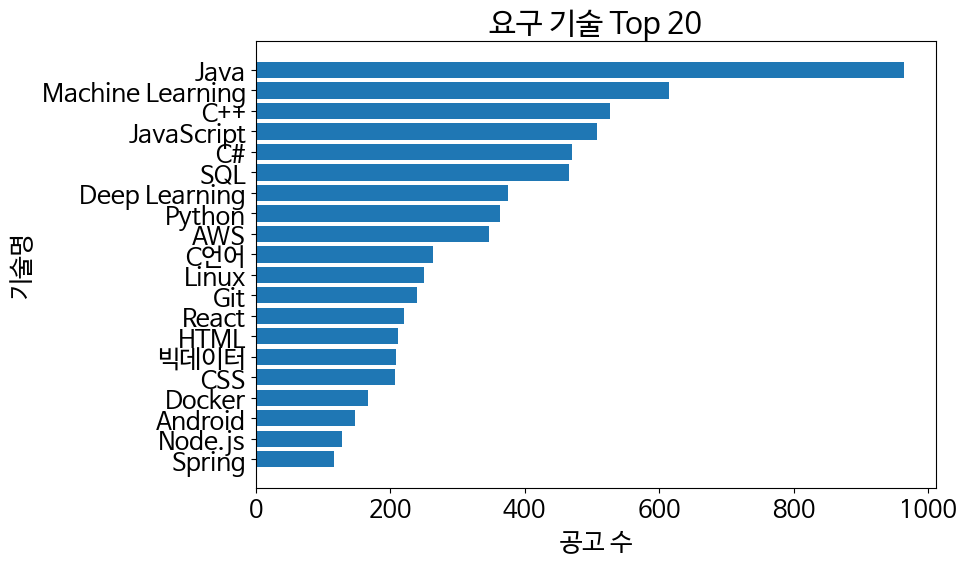

In [ ]:
# 1 라이브러리 불러오기

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 2 CSV 불러오기
df = pd.read_csv("/content/saramin_analysis_cleaned.csv")

# 3 전체 요구 기술 리스트 수집
all_skills = []
for skills in df['skills_normalized']:
    if isinstance(skills, str) and skills.strip() != "":
        all_skills.extend(skills.split(", "))

# 4 기술 빈도 Top 20
skill_counts = Counter(all_skills).most_common(20)

# 5 데이터 분리
skills, counts = zip(*skill_counts)

# 6 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(skills, counts)
plt.title("요구 기술 Top 20")
plt.xlabel("공고 수")
plt.ylabel("기술명")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


**4. 직군별 통계**

[기술과 직군명을 매칭해서 직군 통계를 막대 그래프로 시각화
ex. Java, Spring,Django = 백엔드 개발]

job_field_from_skills
백엔드 개발         1278
데이터/AI         1093
인프라/DevOps      362
임베디드/시스템 개발     278
프론트엔드 개발        206
모바일 개발          163
Name: count, dtype: int64


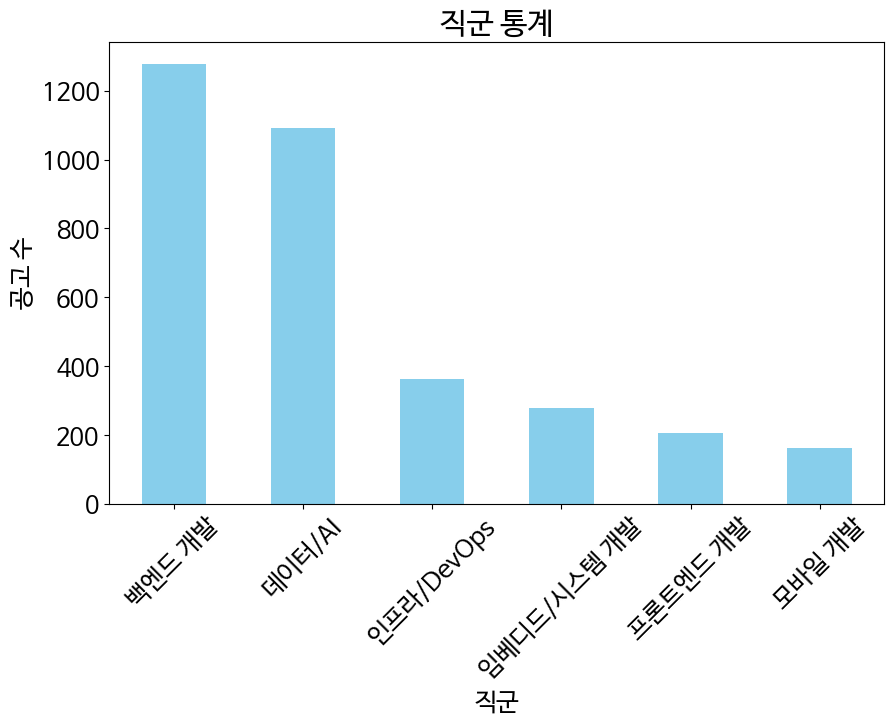

In [ ]:
# 1 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt

# 2 CSV 불러오기
df = pd.read_csv("/content/saramin_analysis_cleaned.csv")

# 3 skills_normalized 기준 직군 추론
def infer_job_field_from_skills(skills_text):
    if not isinstance(skills_text, str) or skills_text.strip() == '':
        return '집계안됨'

    skills = [s.strip() for s in skills_text.split(',')]

    # 데이터 / AI
    if any(s in ['Python', 'TensorFlow', 'Keras', 'ML', 'AI', 'Pandas', 'Numpy',
                 'Scikit-learn', 'Deep Learning', 'Machine Learning', 'LLM', 'XGBoost', 'LightGBM', 'CatBoost'] for s in skills):
        return '데이터/AI'

    # 백엔드
    if any(s in ['Java', 'Spring', 'Spring Boot', 'Django', 'Flask', 'Node.js', 'Express', 'C#'] for s in skills):
        return '백엔드 개발'

    # 프론트엔드
    if any(s in ['HTML', 'CSS', 'JavaScript', 'TypeScript', 'React', 'Vue', 'Angular', 'Next.js', 'Bootstrap'] for s in skills):
        return '프론트엔드 개발'

    # 모바일
    if any(s in ['Android', 'iOS', 'Kotlin', 'Swift', 'Flutter', 'React Native', 'SwiftUI'] for s in skills):
        return '모바일 개발'

    # 임베디드 / 시스템
    if any(s in ['C언어', 'C++'] for s in skills):
        return '임베디드/시스템 개발'

    # 인프라 / DevOps
    if any(s in ['Docker', 'Kubernetes', 'AWS', 'Azure', 'GCP', 'CI/CD', 'Linux', 'Nginx', 'Jenkins', 'Terraform', 'Ansible'] for s in skills):
        return '인프라/DevOps'

    # 기획 / PM
    if any(s in ['서비스기획', 'PM', 'Product'] for s in skills):
        return '기획/PM'

    return '집계안됨'

# 4 적용
df['job_field_from_skills'] = df['skills_normalized'].apply(infer_job_field_from_skills)

# 5 집계안됨 제외
df_filtered = df[df['job_field_from_skills'] != '집계안됨']

# 6 직군별 통계
job_counts = df_filtered['job_field_from_skills'].value_counts()
print(job_counts)

# 7 직군 시각화
plt.figure(figsize=(10,6))
job_counts.plot(kind='bar', color='skyblue')
plt.title('직군 통계')
plt.xlabel('직군')
plt.ylabel('공고 수')
plt.xticks(rotation=45)
plt.show()


**5. 지역별 채용 수요**

[지역별 채용 수요 카운트해서 지도에 서클마커로 시각화]

In [10]:
# 1 라이브러리 불러오기
import pandas as pd
import folium
import random

# 2 데이터 불러오기
df = pd.read_csv("/content/saramin_analysis_cleaned.csv")

# 3 지역별 공고 수 집계
region_count = df['region'].value_counts().reset_index()
region_count.columns = ['지역', '공고수']

# 4 한국 주요 지역 좌표 매핑
coords = {
    "서울": (37.5665, 126.9780),
    "경기": (37.4138, 127.5183),
    "인천": (37.4563, 126.7052),
    "부산": (35.1796, 129.0756),
    "대구": (35.8714, 128.6014),
    "광주": (35.1595, 126.8526),
    "대전": (36.3504, 127.3845),
    "울산": (35.5384, 129.3114),
    "세종": (36.4800, 127.2890),
    "강원도": (37.8228, 128.1555),
    "충북": (36.6285, 127.9293),
    "충남": (36.5184, 126.8000),
    "전북": (35.7175, 127.1530),
    "전남": (34.8160, 126.4630),
    "경북": (36.4919, 128.8889),
    "경남": (35.4606, 128.2132),
    "제주": (33.4996, 126.5312),
}

# 좌표가 존재하는 지역만 필터링
plot_data = region_count[region_count['지역'].isin(coords.keys())].copy()
plot_data["lat"] = plot_data["지역"].map(lambda x: coords[x][0])
plot_data["lon"] = plot_data["지역"].map(lambda x: coords[x][1])

#  5 Folium 지도 생성
m = folium.Map(location=[36.5, 127.8], zoom_start=7)

# 공고 수 기반 마커 추가 (클러스터 없음, 글자 겹치지 않게 약간 위치 랜덤)
for _, row in plot_data.iterrows():
    # lat/lon에 아주 작은 랜덤 오프셋 추가 (±0.03도 정도)
    lat_offset = random.uniform(-0.03, 0.03)
    lon_offset = random.uniform(-0.03, 0.03)
    folium.CircleMarker(
        location=[row['lat'] + lat_offset, row['lon'] + lon_offset],
        radius=5 + row['공고수']/max(plot_data['공고수'])*20,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.6,
        tooltip=folium.Tooltip(f"{row['지역']}: {row['공고수']}개 공고", permanent=True)
    ).add_to(m)

# 6 지도 저장
map_path = "/content/saramin_region_map_no_cluster_offset.html"
m.save(map_path)

m  # Colab에서 지도 바로 표시
#포항은 경북에 포함